<a href="https://colab.research.google.com/github/antopeza/Final-Project-Brainster/blob/main/NEW_code_PV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import os 

import re

import string
from string import punctuation

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import xgboost as xgb

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from nltk.corpus import wordnet, stopwords
from nltk import pos_tag, word_tokenize

import gensim
from gensim.parsing.preprocessing import remove_stopwords

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Embedding, LSTM, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

#from scikeras.wrappers import KerasClassifier

import pickle
from pickle import dump
from pickle import load

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive 
drive.mount('/drive')

Mounted at /drive


In [4]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [5]:
stops = set(stopwords.words('english'))
#print(stops)

In [6]:
stemmer =  PorterStemmer()
lemmer = WordNetLemmatizer()

In [ ]:
# example
print(stemmer.stem('halves'))
print(lemmer.lemmatize('halves'))

In [7]:
#df_raw = pd.read_csv(path)
df_raw = pd.read_csv('/drive/My Drive/MACHINE LEARNING/FINAL PROJECT/train.csv')

In [8]:
print('shape of df  = ', df_raw.shape)
print()
df_raw.head(2)

shape of df  =  (404290, 6)



,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [9]:
df_raw[df_raw.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [10]:
df_raw = df_raw.fillna("")
df_raw.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [11]:
# randomly selected samples from df for the new df to perform operations
df = df_raw.sample(3000)
df = df[['question1', 'question2']]
print(df.shape)

(3000, 2)


In [12]:
def get_wordnet_pos(tag):
    if tag.startswith("N"):
        return wordnet.NOUN
    if tag.startswith("J"):
        return wordnet.ADJ
    if tag.startswith("V"):
        return wordnet.VERB
    if tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN

def clean_sentence(sentence, stopwords = False, lemmatize = False, stem = False):
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)  # removing all caracters that are not alpha numeric
    #sentence = re.sub(r'\s{2,}', ' ', sentence
   
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    
    if stopwords:
        sentence = remove_stopwords(sentence)  
        
    if lemmatize:
        nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
        wn_tagged = map(lambda x: (x[0], get_wordnet_pos(x[1])), nltk_tagged)
        res_words = []
        for word, tag in wn_tagged:
            if tag is None:
                res_words.append(word)
            else :
                res_words.append(lemmer.lemmatize(word, tag))
        sentence = " ".join(res_words)
        
    if stem:
        sent_stemmed = ''
        for word in sentence.split():
            sent_stemmed += ' '+ stemmer.stem(word)
        sentence = sent_stemmed
   
    return sentence

def get_cleaned_senteces(df, stopwords = False, lemmatize = False, stem = False):
    #sents1 = dfq[['question1']]  
    #sents2 = dfq[['question2']]
    cleaned_sentences1 = []
    cleaned_sentences2 = []
    
    for index, row in df.iterrows():
        # print (index, row)
        cleaned1 = clean_sentence(row['question1'], stopwords, lemmatize, stem) 
        cleaned2 = clean_sentence(row['question2'], stopwords, lemmatize, stem)

        cleaned_sentences1.append(cleaned1)
        cleaned_sentences2.append(cleaned2)
    return cleaned_sentences1, cleaned_sentences2

In [13]:
def to_df(q1cleaned, q2cleaned, df):
    '''cleaned sentences to df'''
    X_temp1 = pd.DataFrame()
    X_temp2 = pd.DataFrame()
    X_temp1['q1'] = pd.DataFrame(q1cleaned, index = df.index)
    X_temp2['q2'] = pd.DataFrame(q2cleaned, index = df.index)
    X_temp = pd.concat([X_temp1, X_temp2], axis = 1)
    X_temp['is_duplicate'] = df_raw['is_duplicate']
    return X_temp 

In [14]:
# With stopwords lemmatized, not stemmed
q1_sw, q2_sw = get_cleaned_senteces(df, stopwords = False, lemmatize = True, stem = False)
assert len(q1_sw) == len(q2_sw)
X_sw = to_df(q1_sw, q2_sw, df)
X_sw.shape

(3000, 3)

Value counts:
 0    1918
1    1082
Name: is_duplicate, dtype: int64

Percent of labels value:
 0    63.933333
1    36.066667
Name: is_duplicate, dtype: float64


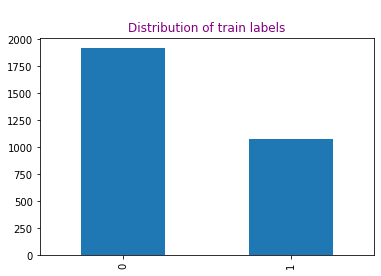

In [15]:
print('Value counts:\n', X_sw['is_duplicate'].value_counts())
print('\nPercent of labels value:\n', X_sw['is_duplicate'].value_counts()/X_sw['is_duplicate'].count()*100)
X_sw['is_duplicate'].value_counts().plot(kind = 'bar')
plt.title('\nDistribution of train labels', color = 'purple', size = 12)
plt.show()

In [16]:
display (X_sw.head(2))
display(df.head(2))

,q1,q2,is_duplicate
280575,why we be always haunt by the idea that we be ...,why do we always impose our opinion and idea o...,0
343565,how be barium sulfate dihydrate formula determine,what be the formula for hydrated sodium sulfat...,0


,question1,question2
280575,Why we are always haunted by the idea that we ...,Why do we always impose our opinions and ideas...
343565,How is barium sulfate dihydrate formula determ...,What is the formula for hydrated sodium sulfat...


# DOC2VEC